## **Introduction to Image Processing, Computer Vision and Deep Learning**
- Project-2
- 2023/12/22

### Table of Contents：
4. **Training a MNIST Classifier Using VGG19 with BN**
    - 4.1 Load Model and Show Model Structure. 
    - 4.2 Show Training/Validating Accuracy and Loss. 
    - 4.3 Use the Model with Highest Validation Accuracy to Run Inference, Show the Predicted Distribution and Class Label. 


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 22 14:38:43 2023
@author: Mr.Jiang
"""
import cv2
import numpy as np
from numpy import zeros, dot, exp, mgrid, pi, ravel, uint8, square
from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton, QVBoxLayout, QWidget, QPlainTextEdit, QLineEdit, QGraphicsView, QGraphicsScene, QFileDialog, QHBoxLayout
from PyQt5.QtGui import QIcon, QPainter, QImage, QPen, QPixmap
from PyQt5.QtCore import Qt, QPoint
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import vgg19_bn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torchvision.models as models
from sklearn.model_selection import train_test_split
from PIL import Image as Image
import random
import sys
import io
import os


In [2]:
# run on Kaggle
import os

# Kaggle input / working
os.listdir("/kaggle/working/") # reset
print(os.listdir('/kaggle/input/hw2-q5-inference-dataset/Hw2_Q5_inference_dataset/'))


['Dog', 'Cat']


In [6]:
# 4.1 Show Model Structure-----------------------------------------------

class Q41():
    def Show_Model_Structure(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = torchvision.models.vgg19_bn(num_classes = 10)
        model = model.to(device)

        # show model structure
        summary(model, (3,32,32)) # input shape

q41 = Q41()
q41.Show_Model_Structure()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

Epoch 1 ------Train Loss: 2.8968 | Train Acc: 23.64%
Epoch 1 --------Val Loss: 2.0155 |   Val Acc: 21.35%
Saved best model at epoch 1  | Val Acc：21.35%
Epoch 5 ------Train Loss: 1.7878 | Train Acc: 29.73%
Epoch 5 --------Val Loss: 1.1849 |   Val Acc: 49.61%
Saved best model at epoch 5  | Val Acc：49.61%
Saved best model at epoch 7  | Val Acc：65.01%
Saved best model at epoch 9  | Val Acc：76.28%
Epoch 10------Train Loss: 0.7623 | Train Acc: 71.28%
Epoch 10--------Val Loss: 0.4093 |   Val Acc: 84.03%
Saved best model at epoch 10 | Val Acc：84.03%
Saved best model at epoch 11 | Val Acc：93.66%
Saved best model at epoch 12 | Val Acc：96.11%
Saved best model at epoch 13 | Val Acc：96.99%
Saved best model at epoch 14 | Val Acc：97.07%
Epoch 15------Train Loss: 0.1521 | Train Acc: 96.33%
Epoch 15--------Val Loss: 0.1270 |   Val Acc: 96.46%
Epoch 20------Train Loss: 0.1964 | Train Acc: 95.56%
Epoch 20--------Val Loss: 1.4638 |   Val Acc: 65.11%
Saved best model at epoch 22 | Val Acc：98.06%
Saved best

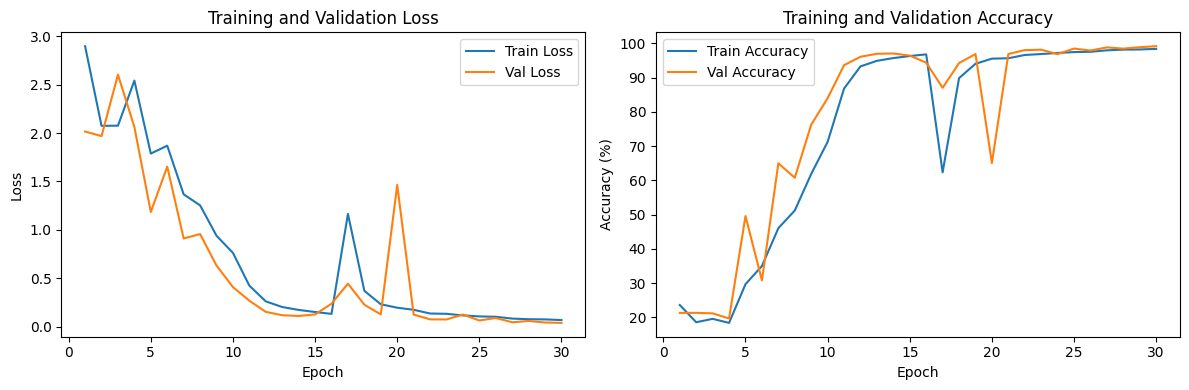

['Best_vgg19_bn_for_MNIST.pth', 'data', 'Vgg19_bn_training_curves.png', '.virtual_documents']


In [6]:
# 4.2 Show Acc and Loss -------------------------------------------------

class Q42():
    def Show_Acc_and_Loss(self, batch_size, epochs, lr):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 1. Data Preprocessing - 在資料端 revise input from 1 channle -> 3

        # Data augmentation for training set
        train_transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomCrop(32, padding=4), # 最終隨機裁剪後圖像的尺寸為 32x32
            # transforms.RandomAffine(degrees=(-10,10),translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.Grayscale(num_output_channels=3), # gray image convert to 3 channles
            transforms.ToTensor(),
            transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))  # 經統計後  MNIST 的均值和標準差
        ])  # Normalize()代表每個灰度圖像從每個像素值中減去 0.1307 (maen)；並將結果除以 0.3081 (std)

        # Data augmentation only normalize for val set
        val_transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3), # gray image convert to 3 channles
            transforms.ToTensor(),
            transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
        ])

        '''
        transforms.RandomAffine(translate(0.1, 0.1), scale(0.9, 1.1)) 隨機仿射變換
            1. translate：在水平和垂直方向上進行隨機平移的最大比例 (tx, ty) -> [-2.8, +2.8]
            2. scale：圖像的縮放比例會在 [0.9, 1.1] 的範圍內隨機選擇

        transforms.ColorJitter(brightness=0.2, contrast=0.2) 隨機調整亮度和對比度
            1. brightness：亮度在 [0.8, 1.2] 的範圍內隨機選擇
            2. contrast：對比度在 [0.8, 1.2] 的範圍內隨機選擇

        transforms.Grayscale(num_output_channels=3)
            1. input：接收一個單 channel（灰度）或多 channel 的 image
            2. convert：如果 input 是彩色，它會將其轉換為灰度；如果輸入已經是灰度，會保持不變
            3. num_output_channels=3：從 (Hight, Width) or (1, Hight, Width) -> (3, Hight, Width)
        '''
        data_root = './data'
        train_dataset = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=train_transform)
        val_dataset = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=val_transform)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2
        )
        '''
        DataLoader：
            1. 當資料集總樣本數無法被批次大小整除時，會產生剩餘樣本，DataLoader 預設為捨棄
            2. 標籤資料由 DataLoader 負責轉換為 PyTorch tensor；影像資料則是由 transforms.ToTensor() 轉換
                - DataLoader 會將標籤資料轉換為 PyTorch tensor，以便與影像資料一起傳遞給模型
            3. num_workers 為一個超參數，用於設定資料載入的子程序數量，可以顯著加速資料載入的速度
                - 子程序負責從資料集中讀取資料，並將資料傳遞給主程序（main process）
                - 主程序負責將資料傳遞給模型進行訓練
        '''
        # 2. load VGG19 model with BatchNorm
        model = vgg19_bn(pretrained=False, num_classes=10)
        model = model.to(device)

        # 3. define Loss function and optimizer
        loss_fn = nn.CrossEntropyLoss() # nn.CrossEntropyLoss() = nn.LogSoftmax() + nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model

        # 4. define train and val
        def train(epoch):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (X, y) in enumerate(train_loader):
                X, y = X.to(device), y.to(device)
                '''
                每個 train_loader 中輸出一個 tuple：
                    1. X(inputs)：一個 shape 為 (batch_size, channels, height, width) 的 tensor
                    2. y(lables)：一個 shape 為 (batch_size) 的 tensor，因為每一筆影像配對一個 label，有幾筆 image = 有幾筆 label
                '''

                # .zero_grad() 將模型所有參數的梯度清零。
                # 是必要的，因為 PyTorch 的梯度會累加，如果不清零，前一批次的梯度會影響當前批次。
                optimizer.zero_grad()

                # Forward Propagation： X (batch_size, channels, height, width) -> y_pred (batch_size, num_classes)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                # Backward Propagation
                loss.backward() # 梯度會儲存在模型參數的 .grad 屬性中，為後續優化步驟做準備
                optimizer.step()
                '''
                optimizer.step()
                    1. 根據計算出的梯度，使用 Optimizer 更新模型參數
                    2. 對於 SGD，更新規則是：param = param − lr × grad
                '''
                running_loss += loss.item() # 累積整個 epoch 的 loss
                _, predicted = torch.max(y_pred, 1)
                '''
                torch.max() 會回傳兩個 tensor：
                    1. 第一個 tensor 包含每個 sample 的最大「值」
                    2. 第二個 tensor 包含每個 sample 最大值的「索引」，也就是預測的「類別」

                舉例：
                outputs = torch.tensor([[0.1, 0.9, 0.2], 表示 batch_size = 3, num_classes = 3
                                        [0.8, 0.1, 0.3],
                                        [0.2, 0.3, 0.5]])

                _, predicted = torch.max(outputs, 1) 會輸出 [1, 0, 2]，shape 由 batch_size 決定
                '''
                total += y.size(0) # .size = .shape 回傳 batch_size；total 代表實際有經過 train 的 sample數
                correct += (predicted == y).sum().item() # .item() 用於從單一元素的 tensor 中取得 Python 數值，多元素會 error

            # calculate acc
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100. * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")

        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for X, y in val_loader:
                    X, y = X.to(device), y.to(device)

                    # Forward Propagation： X (batch_size, channels, height, width) -> y_pred (batch_size, num_classes)
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y) # 注意：這裡計算 loss 僅用於評估，不會用於反向傳播

                    running_loss += loss.item()
                    _, predicted = torch.max(y_pred, 1)
                    total += y.size(0)
                    correct += (predicted == y).sum().item()

            epoch_loss = running_loss / len(val_loader)
            epoch_acc = 100. * correct / total
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")

            # save the bset model
            nonlocal best_val_acc # 使用 nonlocal 允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_vgg19_bn_for_MNIST.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 best_vgg19_bn.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")

        # 5. trainng
        for epoch in range(epochs):
            train(epoch)
            validate(epoch)

        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))

        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # save
        plt.tight_layout()
        plt.savefig('Vgg19_bn_training_curves.png')
        plt.show()

q42 = Q42()
q42.Show_Acc_and_Loss(128, 30, 0.001)
print(os.listdir("/kaggle/working/"))


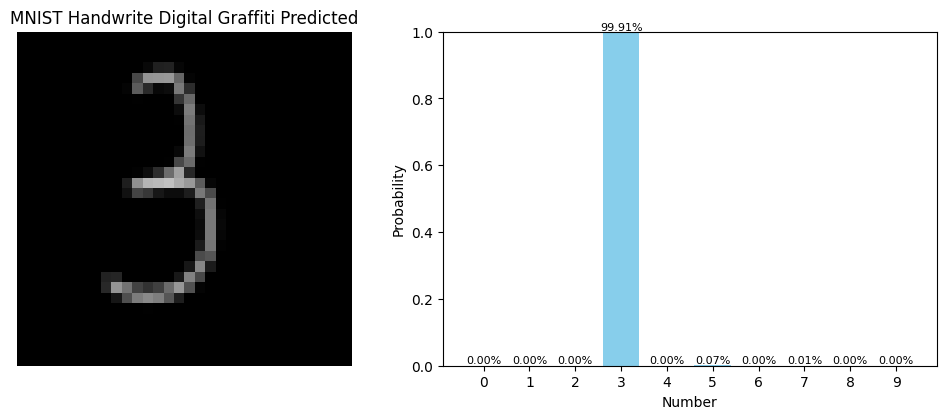

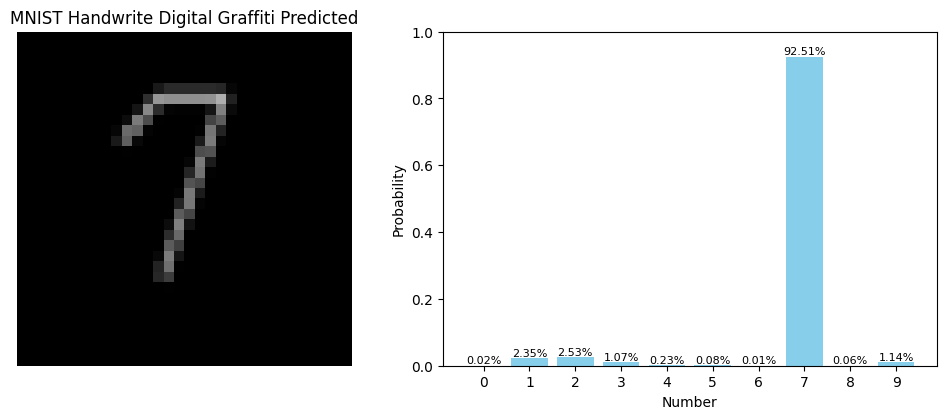

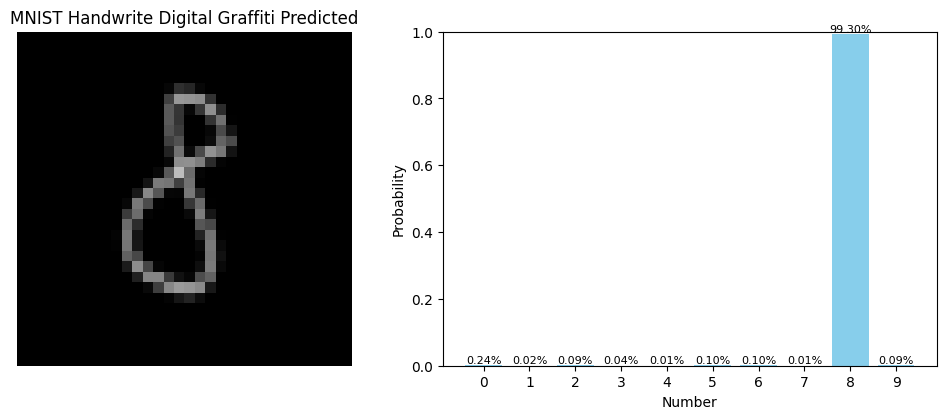

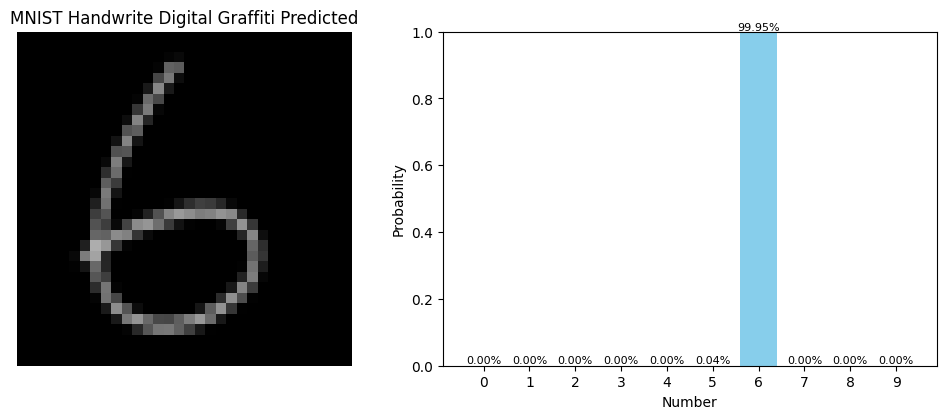

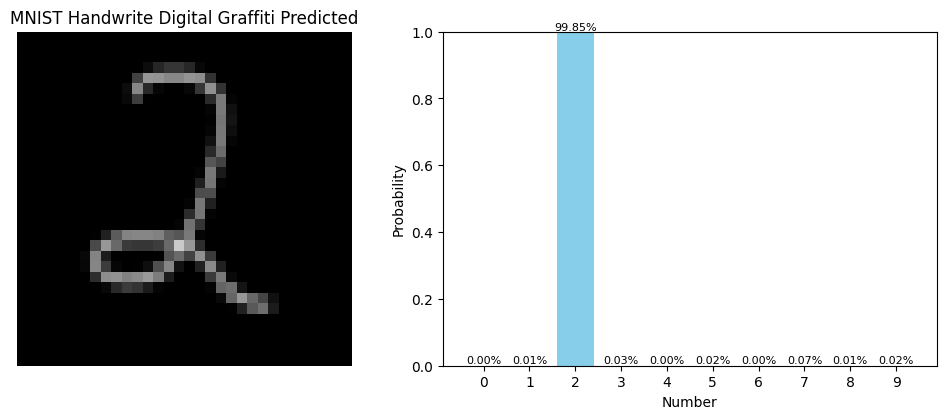

SystemExit: 0

C:\Users\Mr.Jiang\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# 4.3 Show Predicted Distribution and Class Label------------------------

class Q43(): # Model Handler
    def __init__(self):
        # 1. set up model
        self.model = models.vgg19_bn(num_classes=10)  # MNIST 10 classes
        # 2. load weights
        self.model.load_state_dict(torch.load("Best_vgg19_bn_for_MNIST.pth", map_location=torch.device('cpu')))
        self.model.eval()
        # 3. define transform
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
        ])

class PaintWidget(QWidget): # UI Component
    def __init__(self, transform):
        super().__init__()
        self.transform = transform
        self.image = QImage(280, 280, QImage.Format_RGB32)
        self.image.fill(Qt.black)
        self.drawing = False
        self.last_point = QPoint()

    def resizeEvent(self, event):
        new_image = QImage(self.size(), QImage.Format_RGB32)
        new_image.fill(Qt.black)
        painter = QPainter(new_image)
        painter.drawImage(QPoint(), self.image)
        self.image = new_image

    def paintEvent(self, event):
        canvas_painter = QPainter(self)
        canvas_painter.drawImage(self.rect(), self.image, self.image.rect())

    def mousePressEvent(self, event):
        if event.button() == Qt.LeftButton:
            self.drawing = True
            self.last_point = event.pos()

    def mouseMoveEvent(self, event):
        if self.drawing:
            painter = QPainter(self.image)
            pen = QPen(Qt.white, 15, Qt.SolidLine, Qt.RoundCap, Qt.RoundJoin)
            painter.setPen(pen)
            painter.drawLine(self.last_point, event.pos())
            self.last_point = event.pos()
            self.update()

    def mouseReleaseEvent(self, event):
        if event.button() == Qt.LeftButton:
            self.drawing = False

    def clear(self):
        self.image.fill(Qt.black)
        self.update()

    def get_image_tensor(self):
        ptr = self.image.bits()
        ptr.setsize(self.image.byteCount())
        arr = np.array(ptr).reshape(self.image.height(), self.image.width(), 4)
        arr_rgb = arr[:, :, :3]
        gray = cv2.cvtColor(arr_rgb, cv2.COLOR_RGB2GRAY)
        pil_img = Image.fromarray(gray)
        return self.transform(pil_img).unsqueeze(0)

class MainWindow(QWidget): # Main Application
    def __init__(self, model, transform):
        super().__init__()
        self.setWindowTitle("MNIST Handwrite Digital Graffiti Board")
        self.setFixedSize(900, 750)

        self.model = model
        self.canvas = PaintWidget(transform)

        self.predict_btn = QPushButton("Predict")
        self.predict_btn.setFixedWidth(120)
        self.clear_btn = QPushButton("Claer")
        self.clear_btn.setFixedWidth(120)

        self.result_label = QLabel("Predicted：")
        self.result_label.setStyleSheet("font-size: 18px;")

        self.predict_btn.clicked.connect(self.predict_digit)
        self.clear_btn.clicked.connect(self.canvas.clear)

        btn_layout = QHBoxLayout()
        btn_layout.addStretch()
        btn_layout.addWidget(self.predict_btn)
        btn_layout.addSpacing(20)
        btn_layout.addWidget(self.clear_btn)
        btn_layout.addStretch()

        layout = QVBoxLayout()
        layout.addWidget(self.canvas, stretch=5)  # Graffiti Board 佔 5/6
        layout.addLayout(btn_layout, stretch=1)   # bottom 佔 1/6
        layout.addWidget(self.result_label, alignment=Qt.AlignCenter)
        self.setLayout(layout)

    def predict_digit(self):
        img_tensor = self.canvas.get_image_tensor()
        with torch.no_grad():
            outputs = self.model(img_tensor)
            probs = F.softmax(outputs, dim=1).squeeze().numpy()
            pred = int(np.argmax(probs))
            self.result_label.setText(f"Predicted: {pred}")
            self.show_distribution(img_tensor, probs)  # 傳入畫布圖像與機率


    def show_distribution(self, img_tensor, probs):
        img_np = img_tensor.squeeze().numpy()

        # 如果是 (3, 32, 32)，轉為 (32, 32, 3)
        if img_np.shape[0] == 3:
            img_np = np.transpose(img_np, (1, 2, 0))
            # 反 Normalize
            img_np = img_np * 0.3081 + 0.1307
            img_np = np.clip(img_np, 0, 1)
        else:
            # 灰階：還原成 [0, 1]
            img_np = img_np * 0.3081 + 0.1307

        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        fig.subplots_adjust(wspace=0)  # 調整水平間距（wspace 越小 -> 越緊）

        # 左邊顯示手寫圖像
        axs[0].imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        axs[0].set_title("MNIST Handwrite Digital Graffiti Predicted")
        axs[0].axis('off')

        # 右邊顯示機率分布
        bars = axs[1].bar(np.arange(10), probs, color='skyblue')
        for bar in bars:
            height = bar.get_height()  # 獲取柱子高度 = 即概率值
            plt.text(
                    bar.get_x() + bar.get_width() / 2,  # x 位置：柱子中心
                    height,                             # y 位置：柱子頂部
                    f'{height:.2%}',                   # 文字內容：概率值（百分比格式）
                    ha='center',                       # 水平對齊：居中
                    va='bottom',                        # 垂直對齊：底部（文字在柱子上方）
                    fontsize=8
                )
        axs[1].set_xlabel("Number")
        axs[1].set_ylabel("Probability")
        axs[1].set_xticks(np.arange(10))
        axs[1].set_ylim([0, 1])

        plt.tight_layout(pad=0.01)
        plt.show()

if __name__ == "__main__": # Entry Point
    # --- 只有直接執行這個檔案時，以下程式碼才會運行 ---
    app = QApplication(sys.argv)
    q43 = Q43()
    window = MainWindow(q43.model, q43.transform)
    window.show()
    sys.exit(app.exec_())
